# BaarleNet [Part 7d - more loss landscapes]

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def save_viz(model, save_path=None):
    plt.clf()
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    
    h1 = model.model[:2](torch.tensor(probe).float())
    h1 = h1.detach().numpy().reshape(100,100,3)

    h2 = model.model[:3](torch.tensor(probe).float())
    h2 = h2.detach().numpy().reshape(100,100,2)
        
    # First neuron (output index 0)
    j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
    j1 = denorm(np.array(j1)) if j1 else []
    
    # Second neuron (output index 1)  
    j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
    j2 = denorm(np.array(j2)) if j2 else []
    
    j3 = get_relu_joint(model.model[0].weight[2,0].item(), model.model[0].weight[2,1].item(), model.model[0].bias[2].item(), extent=1)
    j3 = denorm(np.array(j3)) if j3 else []
    
    fig=plt.figure(0,(10,10)); 
    for i in range(3):
        ax=fig.add_subplot(2,2,i+1)
        ax.imshow(map.mean(2), cmap='gray')
        ax.imshow(np.flipud(h1[:,:,i]>0), 
                   extent=[0, 960, 960, 0],  # This maps to image coordinates
                   alpha=0.7,
                   cmap='viridis')
        if i==0 and len(j1)>0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
        if i==1 and len(j2)>0: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)
        if i==2 and len(j3)>0: ax.plot([j3[0][0], j3[1][0]], [j3[0][1], j3[1][1]], '--', color='#FFFFFF', linewidth=2)
    
    ax=fig.add_subplot(2,2,4)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    # ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
    #            extent=[0, 960, 960, 0],  # This maps to image coordinates
    #            alpha=0.7,
    #            cmap='viridis')
    
    ax.imshow(np.flipud((h2[:,:,1]-h2[:,:,0])>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    if save_path is not None: plt.savefig(save_path)

In [3]:
def flatten_weight_dict(weight_dict):
    """
    Flatten a dictionary of weight tensors into a single 1D numpy array
    """
    flattened = []
    for name, tensor in weight_dict.items():
        if tensor is not None:
            flattened.append(tensor.cpu().numpy().flatten())
    return np.concatenate(flattened)

def unflatten_to_weight_dict(flattened_weights, reference_dict):
    """
    Convert flattened weights back to the original dictionary structure
    """
    result = {}
    start_idx = 0
    
    for name, tensor in reference_dict.items():
        if tensor is not None:
            shape = tensor.shape
            size = tensor.numel()
            
            # Extract the portion for this parameter
            param_weights = flattened_weights[start_idx:start_idx + size]
            
            # Reshape and convert to tensor
            result[name] = torch.tensor(param_weights.reshape(shape)).float()
            start_idx += size
    
    return result

# Set model weights function (reused from previous code)
def set_model_weights(model, weight_dict):
    """Set model parameters from weight dictionary"""
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = weight_dict[name]

def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
    """Compute loss at current model parameters"""
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        return loss.item()


In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

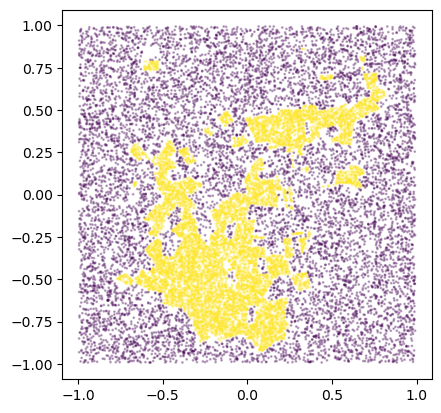

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [6]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
import pickle
import copy
import os

## Run same loop, but save best and worst

Saving results to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_3
Parameter containing:
tensor([[ 1.8001, -2.0338],
        [-1.3064,  1.0897],
        [ 2.4912, -0.6174]], requires_grad=True)

=== Training with seed 0 ===
initial loss =  3.3407106399536133
Epoch [50/500], Loss: 1.0145, Accuracy: 0.3186
Epoch [100/500], Loss: 0.7420, Accuracy: 0.5927
Epoch [150/500], Loss: 0.6966, Accuracy: 0.6190
Epoch [200/500], Loss: 0.6632, Accuracy: 0.6201
Epoch [250/500], Loss: 0.6384, Accuracy: 0.7220
Epoch [300/500], Loss: 0.6180, Accuracy: 0.7277
Epoch [350/500], Loss: 0.5979, Accuracy: 0.7337
Epoch [400/500], Loss: 0.5786, Accuracy: 0.7423
Epoch [450/500], Loss: 0.5630, Accuracy: 0.7491
Epoch [500/500], Loss: 0.5505, Accuracy: 0.7545
*** NEW BEST MODEL: Seed 0, Accuracy 0.7545 ***
*** NEW WORST MODEL: Seed 0, Accuracy 0.7545 ***
Saved training data to /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_3/training_data_se

<Figure size 640x480 with 0 Axes>

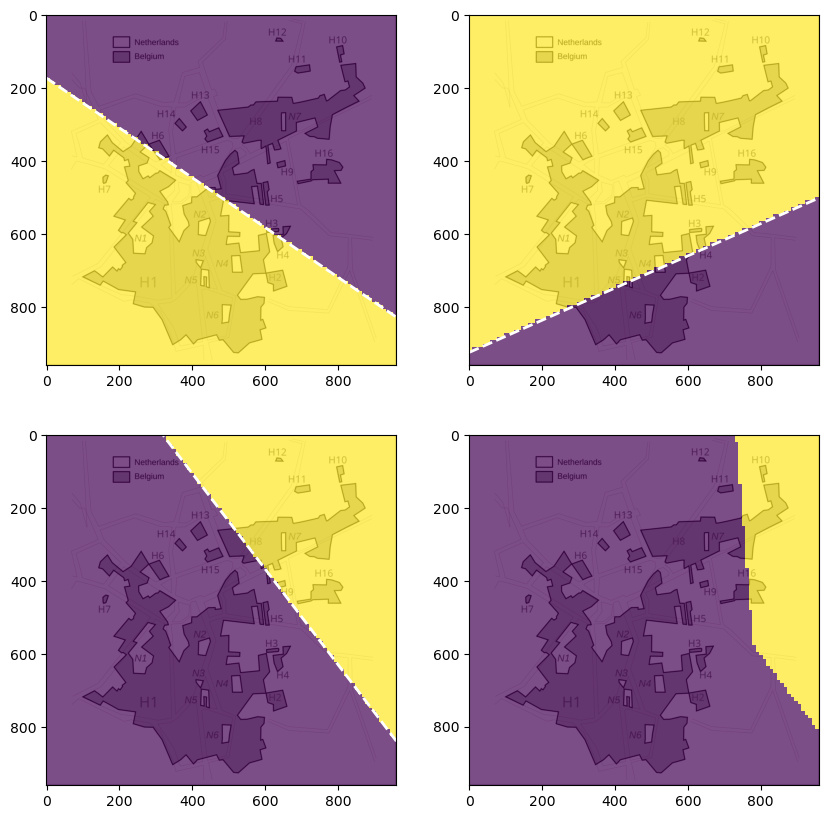

In [8]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Training parameters
num_epochs = 500 #Trying shorter to reduce arbitrary weight scaling
num_seeds = 128 #8 is nice for quick tests

# Configure output directory
output_dir = "/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_4"  # Change this to your desired directory
os.makedirs(output_dir, exist_ok=True)
print(f"Saving results to: {output_dir}")

# Track best and worst models
best_model_data = {'accuracy': -1, 'seed': None, 'initial_params': None, 'final_params': None}
worst_model_data = {'accuracy': float('inf'), 'seed': None, 'initial_params': None, 'final_params': None}
all_training_data=[]

for seed_idx in range(num_seeds):
    random_seed = seed_idx  # You can change this to any seed generation logic
    torch.manual_seed(random_seed)
    
    # Initialize model and optimizer
    model = BaarleNet([3]) #[3] is probaby the move for this
    #Mess with initialization
    bound=3
    with torch.no_grad():
        model.model[0].weight.uniform_(-bound, bound)
        model.model[0].bias.uniform_(-bound, bound)  
        model.model[2].weight.uniform_(-bound, bound)
        model.model[2].bias.uniform_(-bound, bound)  

    print(model.model[0].weight)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Store initial parameters (deep copy)
    initial_params = {}
    for name, param in model.named_parameters():
        initial_params[name] = param.data.clone()
    
    # Data storage for this run
    training_data = {
        'seed': random_seed,
        'weights_history': [],
        'gradients_history': [],
        'xy_history': [],
        'loss_history': [],
        'accuracy_history': [],
        'initial_params': initial_params  # Store initial params in training data too
    }

    print(f"\n=== Training with seed {random_seed} ===")

    for epoch in range(num_epochs):
        # Get current data point
        current_idx = epoch % len(y)
        # Stochastic
        # current_x = torch.tensor(X[current_idx]).float()
        # current_y = torch.tensor(y[current_idx])

        #Try batch for a second
        current_x = torch.tensor(X).float()
        current_y = torch.tensor(y)  
        
        # Forward pass
        outputs = model(current_x)
        loss = criterion(outputs, current_y)
        if epoch==0:
            print('initial loss = ', loss.item())
        
        # Store current X,y values
        training_data['xy_history'].append({
            'epoch': epoch,
            'x': X[current_idx].copy(),
            'y': y[current_idx]
        })
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Store model weights (deep copy to avoid reference issues)
        current_weights = {}
        for name, param in model.named_parameters():
            current_weights[name] = param.data.clone()
        training_data['weights_history'].append(current_weights)
        
        # Store model gradients (deep copy)
        current_gradients = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                current_gradients[name] = param.grad.clone()
            else:
                current_gradients[name] = None
        training_data['gradients_history'].append(current_gradients)
        
        # Update parameters
        optimizer.step()
        
        # Store loss
        training_data['loss_history'].append(loss.item())
        
        # Calculate and store accuracy periodically
        if (epoch + 1) % (num_epochs // 10) == 0:
            with torch.no_grad():
                outputs_batch = model(X_tensor)
                accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
                training_data['accuracy_history'].append({
                    'epoch': epoch,
                    'accuracy': accuracy
                })
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    # Calculate final accuracy
    with torch.no_grad():
        final_outputs = model(X_tensor)
        final_accuracy = (torch.argmax(final_outputs, dim=1) == y_tensor).sum().item() / len(y)
    
    # Store final parameters (deep copy)
    final_params = {}
    for name, param in model.named_parameters():
        final_params[name] = param.data.clone()
    
    # Check if this is the best or worst model so far
    if final_accuracy > best_model_data['accuracy']:
        best_model_data = {
            'accuracy': final_accuracy,
            'seed': random_seed,
            'initial_params': {name: param.clone() for name, param in initial_params.items()},
            'final_params': {name: param.clone() for name, param in final_params.items()}
        }
        print(f"*** NEW BEST MODEL: Seed {random_seed}, Accuracy {final_accuracy:.4f} ***")
    
    if final_accuracy < worst_model_data['accuracy']:
        worst_model_data = {
            'accuracy': final_accuracy,
            'seed': random_seed,
            'initial_params': {name: param.clone() for name, param in initial_params.items()},
            'final_params': {name: param.clone() for name, param in final_params.items()}
        }
        print(f"*** NEW WORST MODEL: Seed {random_seed}, Accuracy {final_accuracy:.4f} ***")
    
    # Save data as pickle file
    filename = os.path.join(output_dir, f"training_data_seed_{random_seed:02d}_acc_{final_accuracy:.4f}.pkl")
    
    # Add final accuracy and params to the data
    training_data['final_accuracy'] = final_accuracy
    training_data['final_model_state'] = model.state_dict()
    training_data['final_params'] = final_params
    
    with open(filename, 'wb') as f:
        pickle.dump(training_data, f)
    
    print(f"Saved training data to {filename}")
    print(f"Final accuracy: {final_accuracy:.4f}")

    # Restore initial weights for visualization
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = training_data['weights_history'][0][name]

    print(model.model[0].weight)
    viz_fn = os.path.join(output_dir, f"{final_accuracy:.4f}_random_init.png")
    save_viz(model, str(viz_fn))

    all_training_data.append(training_data)

# After all training is complete, save best and worst model data
best_worst_data = {
    'best_model': best_model_data,
    'worst_model': worst_model_data
}

best_worst_filename = os.path.join(output_dir, "best_worst_models.pkl")
with open(best_worst_filename, 'wb') as f:
    pickle.dump(best_worst_data, f)

print(f"\n=== FINAL RESULTS ===")
print(f"Best model: Seed {best_model_data['seed']}, Accuracy {best_model_data['accuracy']:.4f}")
print(f"Worst model: Seed {worst_model_data['seed']}, Accuracy {worst_model_data['accuracy']:.4f}")
print(f"Best/worst model data saved to: {best_worst_filename}")

In [36]:
best_model_data

{'accuracy': 0.85105,
 'seed': 76,
 'initial_params': {'model.0.weight': tensor([[-0.6216,  1.4949],
          [-1.9600, -1.7431],
          [ 2.3060, -1.0205]]),
  'model.0.bias': tensor([ 0.3913, -2.9142, -1.1062]),
  'model.2.weight': tensor([[ 0.4840,  0.2952, -1.4141],
          [-0.2739, -1.7991, -0.5716]]),
  'model.2.bias': tensor([ 1.7062, -2.4131])},
 'final_params': {'model.0.weight': tensor([[ 0.7411, -2.1998],
          [-3.6173, -1.6853],
          [ 2.3647, -2.5069]]),
  'model.0.bias': tensor([ 1.4025, -1.8640, -0.0323]),
  'model.2.weight': tensor([[-1.6800,  1.5847,  1.0884],
          [ 1.8901, -3.0886, -3.0741]]),
  'model.2.bias': tensor([ 0.5264, -1.2333])}}

In [38]:
worst_model_data

{'accuracy': 0.4999,
 'seed': 10,
 'initial_params': {'model.0.weight': tensor([[-0.1060,  0.6900],
          [-0.0196, -0.2873],
          [-2.6549, -2.5878]]),
  'model.0.bias': tensor([-2.6996, -2.9355, -2.7940]),
  'model.2.weight': tensor([[-2.2727, -2.7058, -2.8142],
          [ 1.3151,  1.8400,  2.0272]]),
  'model.2.bias': tensor([1.6162, 1.0165])},
 'final_params': {'model.0.weight': tensor([[-0.1060,  0.6900],
          [-0.0196, -0.2873],
          [-1.8511, -1.7834]]),
  'model.0.bias': tensor([-2.6996, -2.9355, -3.5390]),
  'model.2.weight': tensor([[-2.2727, -2.7058, -2.3052],
          [ 1.3151,  1.8400,  1.5182]]),
  'model.2.bias': tensor([1.3164, 1.3163])}}

In [39]:
all_initial_params=[]
all_final_params=[]
all_accuracies=[]
for i, t in enumerate(all_training_data):
    all_initial_params.append(flatten_weight_dict(t['initial_params']))
    all_final_params.append(flatten_weight_dict(t['final_params']))
    all_accuracies.append(t['final_accuracy'])
all_initial_params=np.array(all_initial_params)
all_final_params=np.array(all_final_params)

In [40]:
all_initial_params

array([[ 1.8000684 , -2.0338233 , -1.3063885 , ...,  2.5920024 ,
        -1.944539  , -1.3809986 ],
       [-0.01198447,  2.6225002 ,  0.9335704 , ...,  2.8456664 ,
         1.9801794 , -2.7334132 ],
       [-1.7697948 , -1.1533034 ,  2.8851542 , ..., -1.9469469 ,
         0.7060468 ,  1.9744381 ],
       ...,
       [ 2.443781  ,  2.8359025 , -0.58184445, ...,  0.37383342,
         2.2005582 , -2.8983436 ],
       [-2.1380517 , -0.02700233, -2.9225957 , ...,  0.9170898 ,
         1.9967501 , -2.2354927 ],
       [-1.850627  , -2.7090878 , -1.2642585 , ...,  1.3447766 ,
         1.5491084 ,  1.228716  ]], dtype=float32)

In [41]:
all_final_params

array([[ 3.41143   , -1.4308829 , -0.64767635, ...,  2.6066813 ,
        -0.86821413, -2.457321  ],
       [-2.1542985 ,  0.49225488,  3.7887714 , ...,  1.703521  ,
         0.912084  , -1.6653168 ],
       [-1.889387  ,  0.08438322,  4.897826  , ..., -1.0031581 ,
         0.85763466,  1.822851  ],
       ...,
       [ 1.0492747 ,  1.2393668 , -4.155016  , ...,  2.0756385 ,
         0.06972381, -0.76750976],
       [-1.6342509 ,  0.3155066 , -5.1665525 , ...,  0.71488714,
         1.3884511 , -1.6271942 ],
       [-1.4902266 , -1.4685766 , -1.184339  , ...,  0.613779  ,
         0.9946693 ,  1.783155  ]], dtype=float32)

In [42]:
all_accuracies

[0.7545,
 0.7589,
 0.758,
 0.7839,
 0.79355,
 0.7604,
 0.80095,
 0.7653,
 0.61305,
 0.8261,
 0.4999,
 0.7081,
 0.7189,
 0.60865,
 0.7558,
 0.65295,
 0.7955,
 0.66285,
 0.6633,
 0.7408,
 0.7254,
 0.7701,
 0.65865,
 0.7279,
 0.71085,
 0.7707,
 0.76215,
 0.8408,
 0.7235,
 0.71485,
 0.6105,
 0.60915,
 0.61435,
 0.84895,
 0.83025,
 0.73865,
 0.73935,
 0.84695,
 0.6256,
 0.829,
 0.63755,
 0.78105,
 0.66265,
 0.76465,
 0.7795,
 0.75415,
 0.6547,
 0.7328,
 0.8297,
 0.7855,
 0.6147,
 0.6475,
 0.77915,
 0.5363,
 0.8116,
 0.7274,
 0.7213,
 0.7374,
 0.65125,
 0.686,
 0.8027,
 0.77215,
 0.7717,
 0.79665,
 0.76265,
 0.7408,
 0.7426,
 0.7031,
 0.7966,
 0.7773,
 0.76275,
 0.7788,
 0.78265,
 0.61445,
 0.7619,
 0.8001,
 0.85105,
 0.78015,
 0.65485,
 0.7597,
 0.6939,
 0.65235,
 0.69025,
 0.64145,
 0.83835,
 0.749,
 0.7732,
 0.7308,
 0.834,
 0.6073,
 0.61435,
 0.74095,
 0.7813,
 0.84265,
 0.78455,
 0.7578,
 0.76315,
 0.7554,
 0.7311,
 0.73175,
 0.6092,
 0.6456,
 0.8461,
 0.83395,
 0.79255,
 0.6844,
 0.708

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_final_params)

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

X_umap = reducer.fit_transform(X_scaled)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


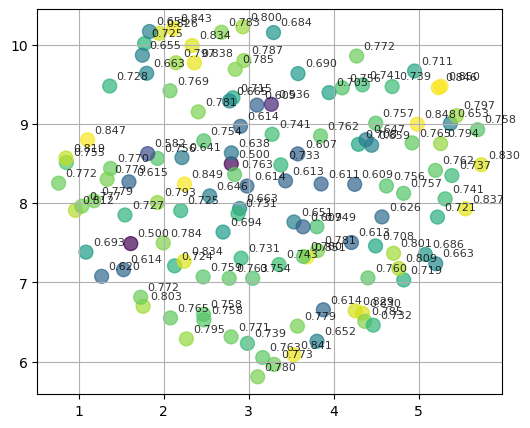

In [45]:
# Create the scatter plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                     c=all_accuracies, 
                     cmap='viridis', 
                     s=100, 
                     alpha=0.7)
plt.grid(1)
for i, accuracy in enumerate(all_accuracies):
    plt.annotate(f'{accuracy:.3f}', 
                (X_umap[i, 0], X_umap[i, 1]),
                xytext=(5, 5),  # offset the text by 5 points
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_initial_params)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

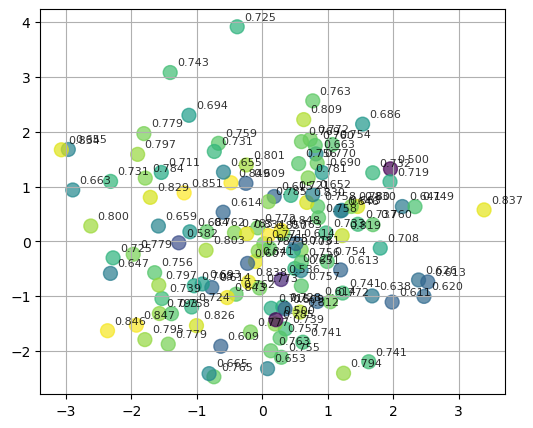

In [47]:
# Create the scatter plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=all_accuracies, 
                     cmap='viridis', 
                     s=100, 
                     alpha=0.7)
plt.grid(1)
for i, accuracy in enumerate(all_accuracies):
    plt.annotate(f'{accuracy:.3f}', 
                (X_pca[i, 0], X_pca[i, 1]),
                xytext=(5, 5),  # offset the text by 5 points
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

In [48]:
all_params=np.vstack((all_initial_params, all_final_params))
all_accuracies_2=all_accuracies+all_accuracies

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_params)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

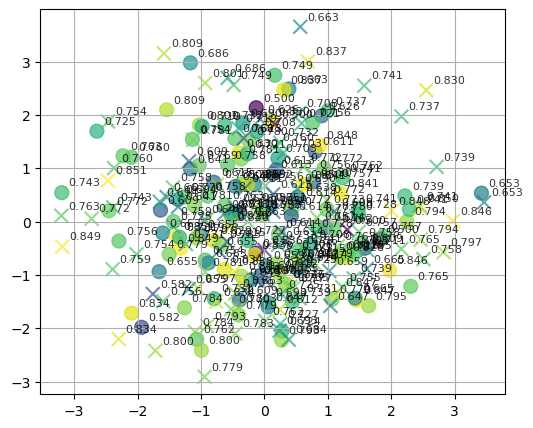

In [50]:
# Create the scatter plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:len(all_params)//2, 0], X_pca[:len(all_params)//2, 1], 
                     c=all_accuracies_2[:len(all_params)//2], 
                     cmap='viridis', 
                     s=100, 
                     marker='o',
                     alpha=0.7)

scatter = plt.scatter(X_pca[len(all_params)//2:, 0], X_pca[len(all_params)//2:, 1], 
                     c=all_accuracies_2[len(all_params)//2:], 
                     cmap='viridis', 
                     s=100, 
                     marker='x',
                     alpha=0.7)

plt.grid(1)
for i, accuracy in enumerate(all_accuracies_2):
    plt.annotate(f'{accuracy:.3f}', 
                (X_pca[i, 0], X_pca[i, 1]),
                xytext=(5, 5),  # offset the text by 5 points
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_final_params)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

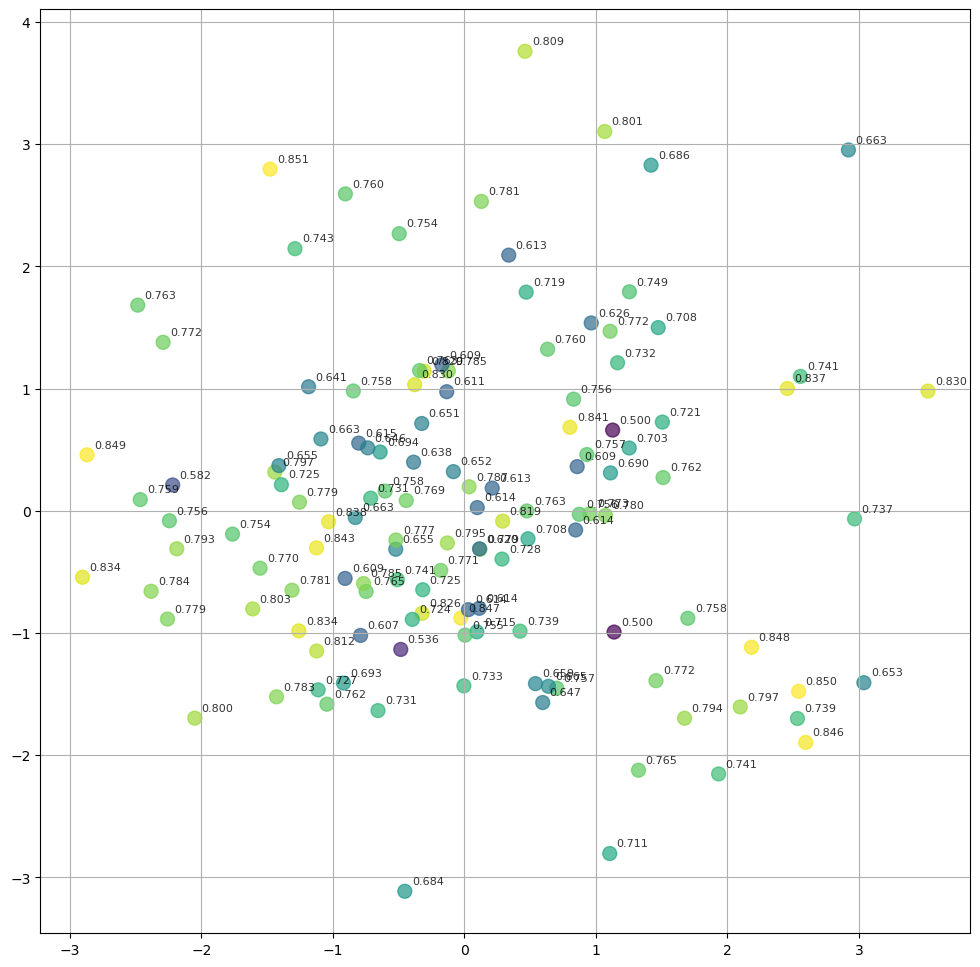

In [53]:
# Create the scatter plot
plt.figure(figsize=(12, 12))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=all_accuracies, 
                     cmap='viridis', 
                     s=100, 
                     alpha=0.7)
plt.grid(1)
for i, accuracy in enumerate(all_accuracies):
    plt.annotate(f'{accuracy:.3f}', 
                (X_pca[i, 0], X_pca[i, 1]),
                xytext=(5, 5),  # offset the text by 5 points
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

In [58]:
def load_best_worst_data(filepath):
    """Load the best and worst model data"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data['best_model'], data['worst_model']

def interpolate_weights(weights1, weights2, alpha):
    """
    Interpolate between two weight dictionaries
    alpha = 0: returns weights1
    alpha = 1: returns weights2
    """
    interpolated = {}
    for name in weights1.keys():
        interpolated[name] = (1 - alpha) * weights1[name] + alpha * weights2[name]
    return interpolated

def set_model_weights(model, weight_dict):
    """Set model parameters from weight dictionary"""
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data = weight_dict[name]

def compute_loss_at_point(model, X_tensor, y_tensor, criterion):
    """Compute loss at current model parameters"""
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        return loss.item()

def create_loss_landscape_2d(best_model_data, worst_model_data, X_tensor, y_tensor, 
                           model_class, model_args, resolution=50, output_dir=None):
    """
    Create 2D loss landscape visualization
    
    Dimension 1 (x-axis): Best model initial -> Best model final
    Dimension 2 (y-axis): Worst model initial -> Best model final
    """
    
    # Create a fresh model for evaluation
    model = model_class(model_args)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Create interpolation grids
    alphas = np.linspace(0, 1, resolution)
    betas = np.linspace(0, 1, resolution)
    
    # Initialize loss landscape
    loss_landscape = np.zeros((resolution, resolution))
    
    print("Computing loss landscape...")
    
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            # Create a proper 2D interpolation grid
            # We want to interpolate between 4 corner points:
            # (0,0) = best_initial
            # (1,0) = best_final  
            # (0,1) = worst_initial
            # (1,1) = worst_final
            
            # Use bilinear interpolation
            # First interpolate along the bottom edge (beta=0): best_initial -> best_final
            bottom_edge = interpolate_weights(
                best_model_data['initial_params'],
                best_model_data['final_params'], 
                alpha
            )
            
            # Then interpolate along the top edge (beta=1): worst_initial -> best_final
            top_edge = interpolate_weights(
                worst_model_data['initial_params'],
                # best_model_data['final_params'],
                worst_model_data['final_params'], #SW Mod
                alpha
            )
            
            # Finally interpolate between bottom and top edges
            final_weights = interpolate_weights(bottom_edge, top_edge, beta)
            
            # Set model weights and compute loss
            set_model_weights(model, final_weights)
            loss = compute_loss_at_point(model, X_tensor, y_tensor, criterion)
            loss_landscape[j, i] = loss
        
        if i % 10 == 0:
            print(f"Progress: {i}/{resolution}")
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    
    # Create contour plot
    X, Y = np.meshgrid(alphas, betas)
    contour = plt.contour(X, Y, loss_landscape, levels=20, colors='black', alpha=0.6, linewidths=0.8)
    contourf = plt.contourf(X, Y, loss_landscape, levels=50, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(contourf)
    cbar.set_label('Loss', fontsize=12)
    
    # Add contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # Mark key points
    plt.plot(0, 0, 'ro', markersize=10, label=f'Best Initial (Acc: {best_model_data["accuracy"]:.3f})')
    plt.plot(1, 0, 'go', markersize=10, label=f'Best Final (Acc: {best_model_data["accuracy"]:.3f})')  
    plt.plot(0, 1, 'bo', markersize=10, label=f'Worst Initial (Acc: {worst_model_data["accuracy"]:.3f})')
    plt.plot(1, 1, 'go', markersize=8, alpha=0.7)  # Same as best final
    
    # Add arrows to show the training trajectories
    plt.annotate('', xy=(1, 0), xytext=(0, 0), 
                arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.7),
                label='Best model training path')
    
    # Labels and title
    plt.xlabel('Best Model: Initial → Final', fontsize=12)
    plt.ylabel('Worst Initial → Best Final', fontsize=12)
    plt.title('2D Loss Landscape\nInterpolating Between Key Weight Configurations', fontsize=14)
    
    # Legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    
    # Grid
    plt.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if output directory specified
    if output_dir:
        viz_path = os.path.join(output_dir, 'loss_landscape_2d.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"Loss landscape saved to: {viz_path}")
    
    plt.show()
    
    return loss_landscape, alphas, betas

Computing loss landscape...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13594/3818586867.py:121: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))


Loss landscape saved to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_3/loss_landscape_2d.png


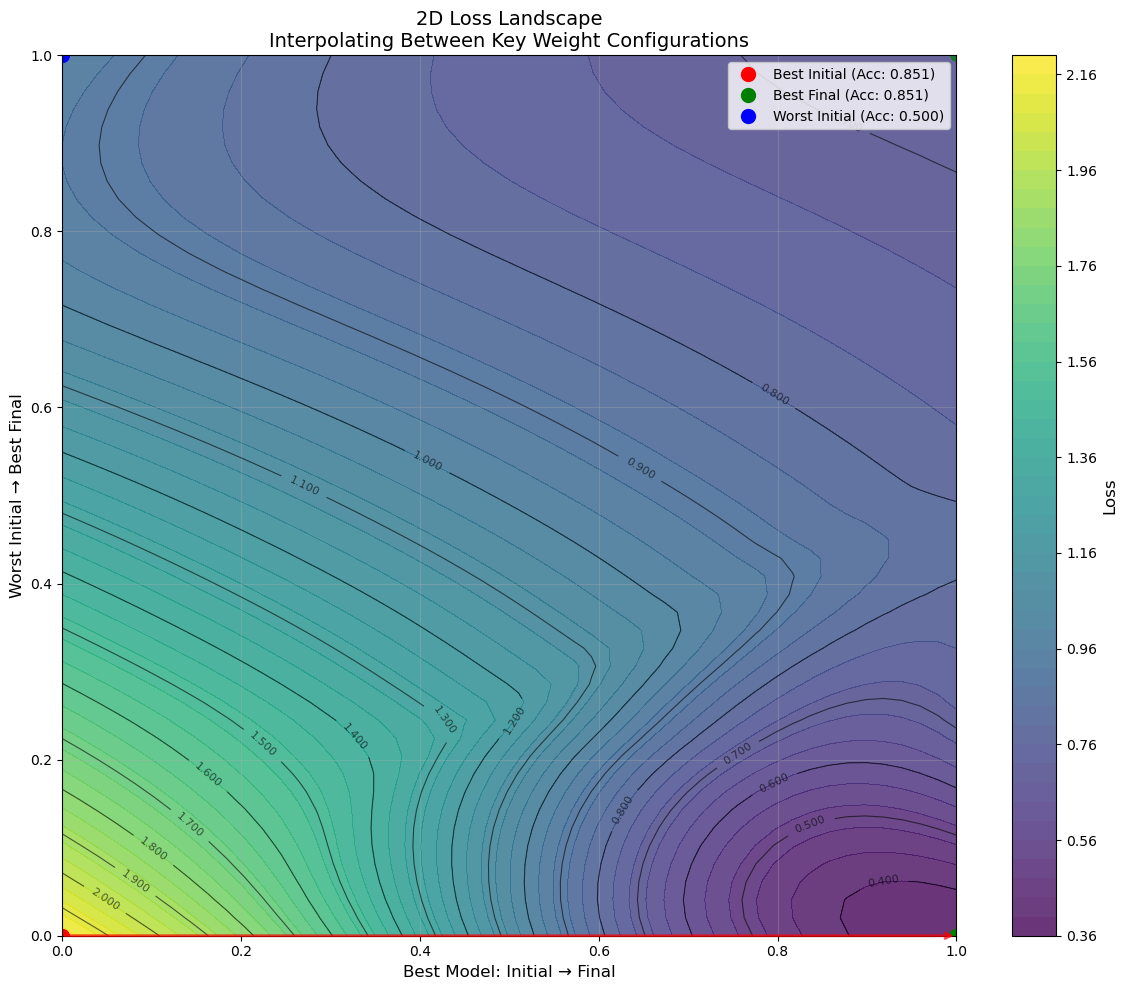

In [59]:
loss_landscape, alphas, betas = create_loss_landscape_2d(
    best_model_data, 
    worst_model_data, 
    X_tensor, 
    y_tensor,
    BaarleNet,  # Your model class
    [3],        # Your model args
    resolution=50,
    output_dir=output_dir
)

- Hey that's kinda what I wanted -> right? Can I just do this?
- Maybe changing my weight initialization helped here?

In [61]:
all_training_data[0].keys()

dict_keys(['seed', 'weights_history', 'gradients_history', 'xy_history', 'loss_history', 'accuracy_history', 'initial_params', 'final_accuracy', 'final_model_state', 'final_params'])

In [65]:
final_accuracies=np.array([t['final_accuracy'] for t in all_training_data])
sI=np.argsort(final_accuracies)

In [66]:
final_accuracies[sI[:5]]

array([0.4999 , 0.5    , 0.5363 , 0.58245, 0.6073 ])

In [67]:
sI[:5]

array([ 10, 107,  53, 116,  89])

In [83]:
i=89

In [84]:
worst_model_data_2 = {
    'accuracy': all_training_data[i]['final_accuracy'],
    'seed': all_training_data[i]['seed'],
    'initial_params': all_training_data[i]['initial_params'],
    'final_params': all_training_data[i]['final_params']
}


In [85]:
worst_model_data_2

{'accuracy': 0.6073,
 'seed': 89,
 'initial_params': {'model.0.weight': tensor([[ 2.2434,  1.4565],
          [-1.3462,  2.3677],
          [-1.1537,  1.7052]]),
  'model.0.bias': tensor([ 0.8051, -0.9677,  0.7008]),
  'model.2.weight': tensor([[-0.4335, -0.0203, -2.5029],
          [-1.7468,  2.1559,  2.6181]]),
  'model.2.bias': tensor([-0.8205, -0.8069])},
 'final_params': {'model.0.weight': tensor([[ 0.5278,  2.6150],
          [-0.3712,  1.5125],
          [ 0.2181,  0.6728]]),
  'model.0.bias': tensor([ 0.6551, -1.7331,  0.1308]),
  'model.2.weight': tensor([[-0.3483,  0.6253, -1.7197],
          [-1.8320,  1.5103,  1.8349]]),
  'model.2.bias': tensor([-1.0817, -0.5457])}}

Computing loss landscape...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_13594/3818586867.py:121: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))


Loss landscape saved to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/3_starting_configs_3/loss_landscape_2d.png


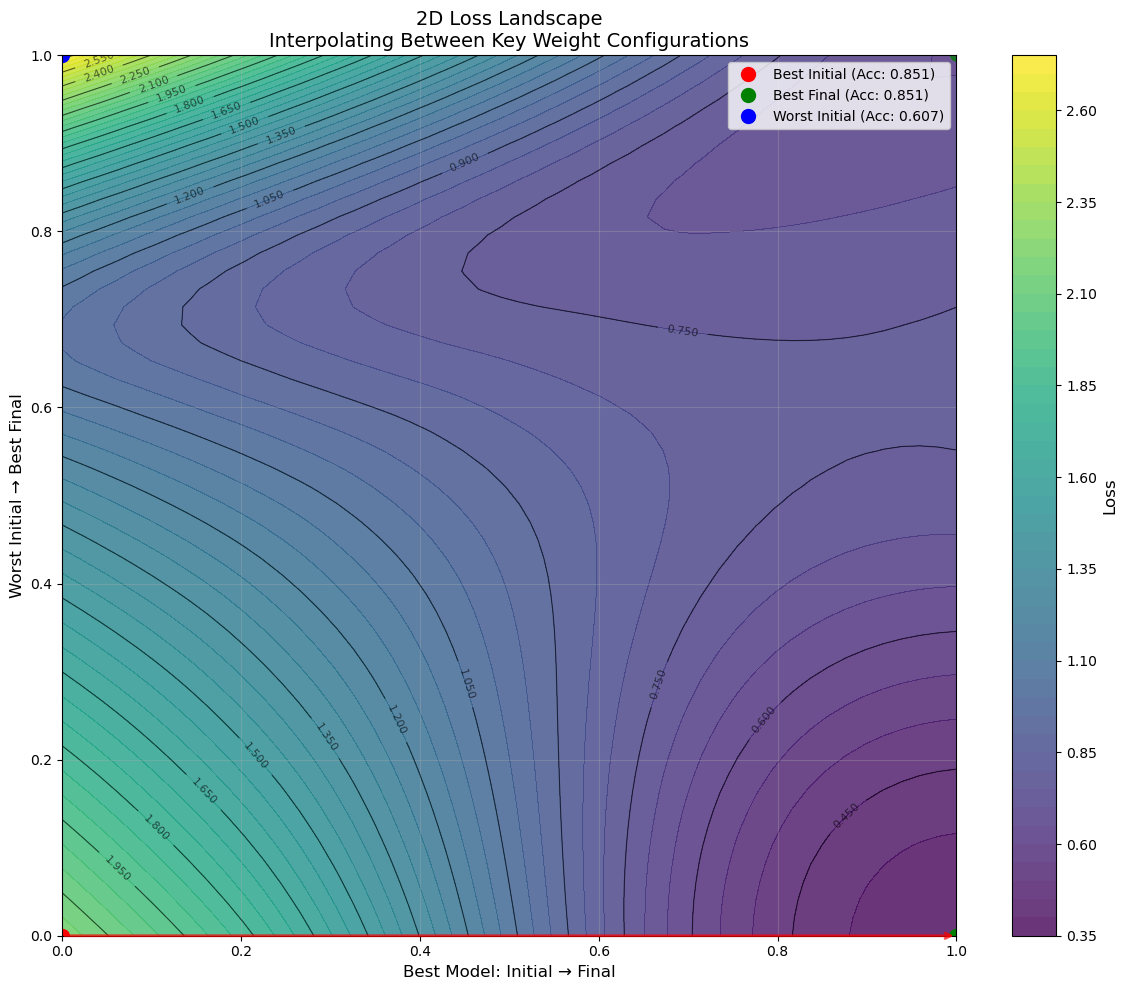

In [86]:
loss_landscape, alphas, betas = create_loss_landscape_2d(
    best_model_data, 
    worst_model_data_2, 
    X_tensor, 
    y_tensor,
    BaarleNet,  # Your model class
    [3],        # Your model args
    resolution=50,
    output_dir=output_dir
)

In [23]:
all_accuracies

[0.7545,
 0.7589,
 0.758,
 0.7839,
 0.79355,
 0.7604,
 0.80095,
 0.7653,
 0.61305,
 0.8261,
 0.4999,
 0.7081,
 0.7189,
 0.60865,
 0.7558,
 0.65295,
 0.7955,
 0.66285,
 0.6633,
 0.7408,
 0.7254,
 0.7701,
 0.65865,
 0.7279,
 0.71085,
 0.7707,
 0.76215,
 0.8408,
 0.7235,
 0.71485,
 0.6105,
 0.60915,
 0.61435,
 0.84895,
 0.83025,
 0.73865,
 0.73935,
 0.84695,
 0.6256,
 0.829,
 0.63755,
 0.78105,
 0.66265,
 0.76465,
 0.7795,
 0.75415,
 0.6547,
 0.7328,
 0.8297,
 0.7855,
 0.6147,
 0.6475,
 0.77915,
 0.5363,
 0.8116,
 0.7274,
 0.7213,
 0.7374,
 0.65125,
 0.686,
 0.8027,
 0.77215,
 0.7717,
 0.79665,
 0.76265,
 0.7408,
 0.7426,
 0.7031,
 0.7966,
 0.7773,
 0.76275,
 0.7788,
 0.78265,
 0.61445,
 0.7619,
 0.8001,
 0.85105,
 0.78015,
 0.65485,
 0.7597,
 0.6939,
 0.65235,
 0.69025,
 0.64145,
 0.83835,
 0.749,
 0.7732,
 0.7308,
 0.834,
 0.6073,
 0.61435,
 0.74095,
 0.7813,
 0.84265,
 0.78455,
 0.7578,
 0.76315,
 0.7554,
 0.7311,
 0.73175,
 0.6092,
 0.6456,
 0.8461,
 0.83395,
 0.79255,
 0.6844,
 0.708

---

In [24]:
len(all_training_data)

128

In [25]:
all_training_data[0].keys()

dict_keys(['seed', 'weights_history', 'gradients_history', 'xy_history', 'loss_history', 'accuracy_history', 'initial_params', 'final_accuracy', 'final_model_state', 'final_params'])

In [26]:
all_training_data[0]['initial_params']

{'model.0.weight': tensor([[ 1.8001, -2.0338],
         [-1.3064,  1.0897],
         [ 2.4912, -0.6174]]),
 'model.0.bias': tensor([ 2.2449, -0.4836,  0.3174]),
 'model.2.weight': tensor([[ 2.7164, -2.7830, -1.8886],
         [-0.7595, -1.1694,  2.5920]]),
 'model.2.bias': tensor([-1.9445, -1.3810])}

In [27]:
all_training_data[0]['final_params']

{'model.0.weight': tensor([[ 3.4114, -1.4309],
         [-0.6477,  0.4900],
         [ 1.6422, -0.8892]]),
 'model.0.bias': tensor([ 1.0509, -1.1085,  1.1633]),
 'model.2.weight': tensor([[ 2.3894, -2.3463, -1.9033],
         [-0.4325, -1.6061,  2.6067]]),
 'model.2.bias': tensor([-0.8682, -2.4573])}

In [28]:
all_training_data[2]['final_params']

{'model.0.weight': tensor([[-1.8894,  0.0844],
         [ 4.8978, -2.0673],
         [ 1.0954, -1.5990]]),
 'model.0.bias': tensor([ 2.1121, -0.8457,  1.5869]),
 'model.2.weight': tensor([[-0.2606, -1.0576, -2.6442],
         [-1.3409, -3.3475, -1.0032]]),
 'model.2.bias': tensor([0.8576, 1.8229])}

In [29]:
all_training_data[2]['final_accuracy']

0.758

In [30]:
flatten_weight_dict(all_training_data[0]['initial_params'])

array([ 1.8000684 , -2.0338233 , -1.3063885 ,  1.0896513 ,  2.4911637 ,
       -0.6174005 ,  2.2449353 , -0.48355007,  0.3174423 ,  2.7164288 ,
       -2.783011  , -1.8886138 , -0.75949574, -1.1693999 ,  2.5920024 ,
       -1.944539  , -1.3809986 ], dtype=float32)

In [31]:
flatten_weight_dict(all_training_data[0]['initial_params'])

array([ 1.8000684 , -2.0338233 , -1.3063885 ,  1.0896513 ,  2.4911637 ,
       -0.6174005 ,  2.2449353 , -0.48355007,  0.3174423 ,  2.7164288 ,
       -2.783011  , -1.8886138 , -0.75949574, -1.1693999 ,  2.5920024 ,
       -1.944539  , -1.3809986 ], dtype=float32)

In [32]:
flatten_weight_dict(all_training_data[0]['final_params'])

array([ 3.41143   , -1.4308829 , -0.64767635,  0.49004903,  1.6422285 ,
       -0.8891952 ,  1.0509201 , -1.1084635 ,  1.1633433 ,  2.3894124 ,
       -2.3463197 , -1.9032907 , -0.43247867, -1.6060909 ,  2.6066813 ,
       -0.86821413, -2.457321  ], dtype=float32)

In [33]:
all_training_data[0]['final_accuracy']

0.7545

In [34]:
flatten_weight_dict(all_training_data[0]['weights_history'][0])

array([ 1.8000684 , -2.0338233 , -1.3063885 ,  1.0896513 ,  2.4911637 ,
       -0.6174005 ,  2.2449353 , -0.48355007,  0.3174423 ,  2.7164288 ,
       -2.783011  , -1.8886138 , -0.75949574, -1.1693999 ,  2.5920024 ,
       -1.944539  , -1.3809986 ], dtype=float32)

In [35]:
flatten_weight_dict(all_training_data[0]['weights_history'][1000])

IndexError: list index out of range

In [ ]:
set_model_weights(model, worst_model_data['initial_params'])
compute_loss_at_point(model, X_tensor, y_tensor, criterion)

In [ ]:
save_viz(model)